In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import streamlit as st
import plotly.express as px
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from pyngrok import ngrok
import time

In [2]:
DATA_PATH = "../Data/cleaned_real_estate_data.csv"

In [3]:
def load_data(path):
    print(f"Loading data from {path}...")
    df = pd.read_csv(path, parse_dates=["snapshot_date", "data_gen_date"],nrows=10000)
    print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns.")

    return df

In [5]:

def feature_engineering(df):
    print("=== Starting Feature Engineering ===")
    df = df.copy()
    df['property_age'] = df['snapshot_date'].dt.year - df['year_built']
    df['total_baths_final'] = (
        df['homeData.bathInfo.computedFullBaths'] +
        0.5 * df['homeData.bathInfo.computedPartialBaths']
    )
    df['lot_size_acres_calc'] = df['lot_size_sqft'] / 43560
    df['log_price'] = np.log1p(df['price'])
    df['log_living_area'] = np.log1p(df['living_area_sqft'])
    df['price_per_sqft_calc'] = df['price'] / df['living_area_sqft']
    df['is_pacific'] = df['timezone'].str.contains('Pacific').astype(int)
    print("Feature engineering completed.\n")
    return df


In [ ]:
#FEATURE SELECTION 

import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(df):
    print("=== Plotting Feature Distributions ===")

    # List of features to SELECTED
    features = [
        'property_age', 'total_baths_final', 'lot_size_acres_calc',
        'log_price', 'log_living_area', 'price_per_sqft_calc', 'is_pacific'
    ]

    plt.figure(figsize=(12, 10))

    # Create subplots for each feature
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 3, i)
        sns.histplot(df[feature], kde=True, color='blue', bins=30)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    print("Feature distribution plots completed.\n")


In [23]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json

def train_models(df):
    print("=== Starting Modeling ===")
    features = [
        'beds', 'property_age', 'total_baths_final',
        'living_area_sqft', 'lot_size_acres_calc',
        'price_per_sqft_calc', 'is_pacific'
    ]
    X = df[features]
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)

    print("linear Regression done")
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print("Random forest done")
    # Support Vector Machine
    svm = SVR()
    svm.fit(X_train_scaled, y_train)
    y_pred_svm = svm.predict(X_test_scaled)
    print("SVR done")
    # XGBoost
    xgbr = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgbr.fit(X_train, y_train)
    y_pred_xgb = xgbr.predict(X_test)
    print("XGBR done")
    # Define threshold for binary classification metrics
    median_price = y.median()
    y_test_class = (y_test > median_price).astype(int)

    results = {}
    print("Model Evaluation Results generating:")
    for name, y_pred in [
        ('LinearRegression', y_pred_lr),
        ('RandomForest', y_pred_rf),
        ('SVM', y_pred_svm),
        ('XGBoost', y_pred_xgb)
    ]:
        print(f"--- {name} ---")
        y_pred_class = (y_pred > median_price).astype(int)
        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred),
            'Accuracy': accuracy_score(y_test_class, y_pred_class),
            'Precision': precision_score(y_test_class, y_pred_class),
            'Recall': recall_score(y_test_class, y_pred_class),
            'F1': f1_score(y_test_class, y_pred_class),
            'ROC AUC': roc_auc_score(y_test_class, y_pred)
        }

        # STEP 3: Save to JSON
        with open("../Data/model_metrics.json", "w") as f:
            json.dump(results, f, indent=4)
        print("Saved model_metrics.json")



    print("Model Evaluation Results:")
    for model, metrics in results.items():
        print(f"--- {model} ---")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")
        print()

    # Feature importances for Random Forest
    importances = rf.feature_importances_
    fi_df = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print("Random Forest Feature Importances:\n", fi_df)
    print("Modeling completed.\n")

    # Save ROC curve plots
    for model_name, y_pred in [
        ('LinearRegression', y_pred_lr),
        ('RandomForest', y_pred_rf),
        ('SVM', y_pred_svm),
        ('XGBoost', y_pred_xgb)
    ]:
        fpr, tpr, _ = roc_curve(y_test_class, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} ROC Curve (AUC = {roc_auc_score(y_test_class, y_pred):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.savefig(f'../Reports/Graphs/{model_name}_roc_curve.png')
        plt.close()

    return lr, rf, svm, xgbr, scaler, X_test, y_test, y_pred_lr, y_pred_rf, y_pred_svm, y_pred_xgb




In [24]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import Image
from reportlab.lib.units import inch

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

import pandas as pd
import numpy as np
import os

def draw_section_title(c, title, y, size=14):
    c.setFont("Helvetica-Bold", size)
    c.setFillColor(colors.darkblue)
    c.drawString(50, y, title)
    c.setFillColor(colors.black)
    return y - 20

def generate_pdf_report(y_test, y_pred_lr, y_pred_rf, y_pred_svm, y_pred_xgb, output_path='../Reports/report.pdf'):
    print("Generating PDF report...")
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter
    margin = 50
    y = height - margin

    # Header
    c.setFont("Helvetica-Bold", 18)
    c.drawString(margin, y, " Real Estate Model Evaluation Report")
    y -= 30

    c.setFont("Helvetica", 12)
    c.drawString(margin, y, f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    y -= 25

    # Section: Model Metrics
    y = draw_section_title(c, "Model Performance Metrics", y)

    median_price = np.median(y_test)
    y_test_class = (y_test > median_price).astype(int)

    def evaluate_model(name, y_pred):
        y_pred_class = (y_pred > median_price).astype(int)
        return {
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R² Score": r2_score(y_test, y_pred),
            "Accuracy": accuracy_score(y_test_class, y_pred_class),
            "Precision": precision_score(y_test_class, y_pred_class),
            "Recall": recall_score(y_test_class, y_pred_class),
            "F1 Score": f1_score(y_test_class, y_pred_class),
            "ROC AUC": roc_auc_score(y_test_class, y_pred)
        }

    metrics_dict = {
        "Linear Regression": evaluate_model("Linear Regression", y_pred_lr),
        "Random Forest": evaluate_model("Random Forest", y_pred_rf),
        "SVM": evaluate_model("SVM", y_pred_svm),
        "XGBoost": evaluate_model("XGBoost", y_pred_xgb)
    }

    for model_name, metrics in metrics_dict.items():
        c.setFont("Helvetica-Bold", 13)
        c.drawString(margin, y, model_name)
        y -= 18
        c.setFont("Helvetica", 11)
        for metric_name, value in metrics.items():
            c.drawString(margin + 20, y, f"{metric_name}: {value:.4f}")
            y -= 15
        y -= 10

    # Comparison Table
    y = draw_section_title(c, "Comparison Summary Table", y)

    c.setFont("Helvetica-Bold", 11)
    headers = ["Metric", "Linear Regression", "Random Forest", "SVM", "XGBoost"]
    col_x = [margin, margin + 120, margin + 250, margin + 380, margin + 500]
    for i, h in enumerate(headers):
        c.drawString(col_x[i], y, h)
    y -= 15
    c.setFont("Helvetica", 10)

    metric_names = list(metrics_dict["Linear Regression"].keys())
    for metric_name in metric_names:
        c.drawString(col_x[0], y, metric_name)
        for i, model in enumerate(["Linear Regression", "Random Forest", "SVM", "XGBoost"]):
            val = metrics_dict[model][metric_name]
            c.drawString(col_x[i + 1], y, f"{val:.4f}")
        y -= 12

    y -= 20
    c.line(margin, y, width - margin, y)
    y -= 15

    # ROC Curve Plots
    for model_name in ['LinearRegression', 'RandomForest', 'SVM', 'XGBoost']:
        img_path = f'{model_name}_roc_curve.png'
        if os.path.exists(img_path):
            if y < 250:
                c.showPage()
                y = height - margin
            y = draw_section_title(c, f"ROC Curve - {model_name}", y)
            c.drawImage(img_path, margin, y - 200, width=5.5*inch, height=3.5*inch)
            y -= 220

    c.save()
    print(f"PDF report saved to {output_path}\n")

Loading data from ../Data/cleaned_real_estate_data.csv...
Loaded 10000 rows and 28 columns.
=== Starting Feature Engineering ===
Feature engineering completed.

=== Plotting Feature Distributions ===


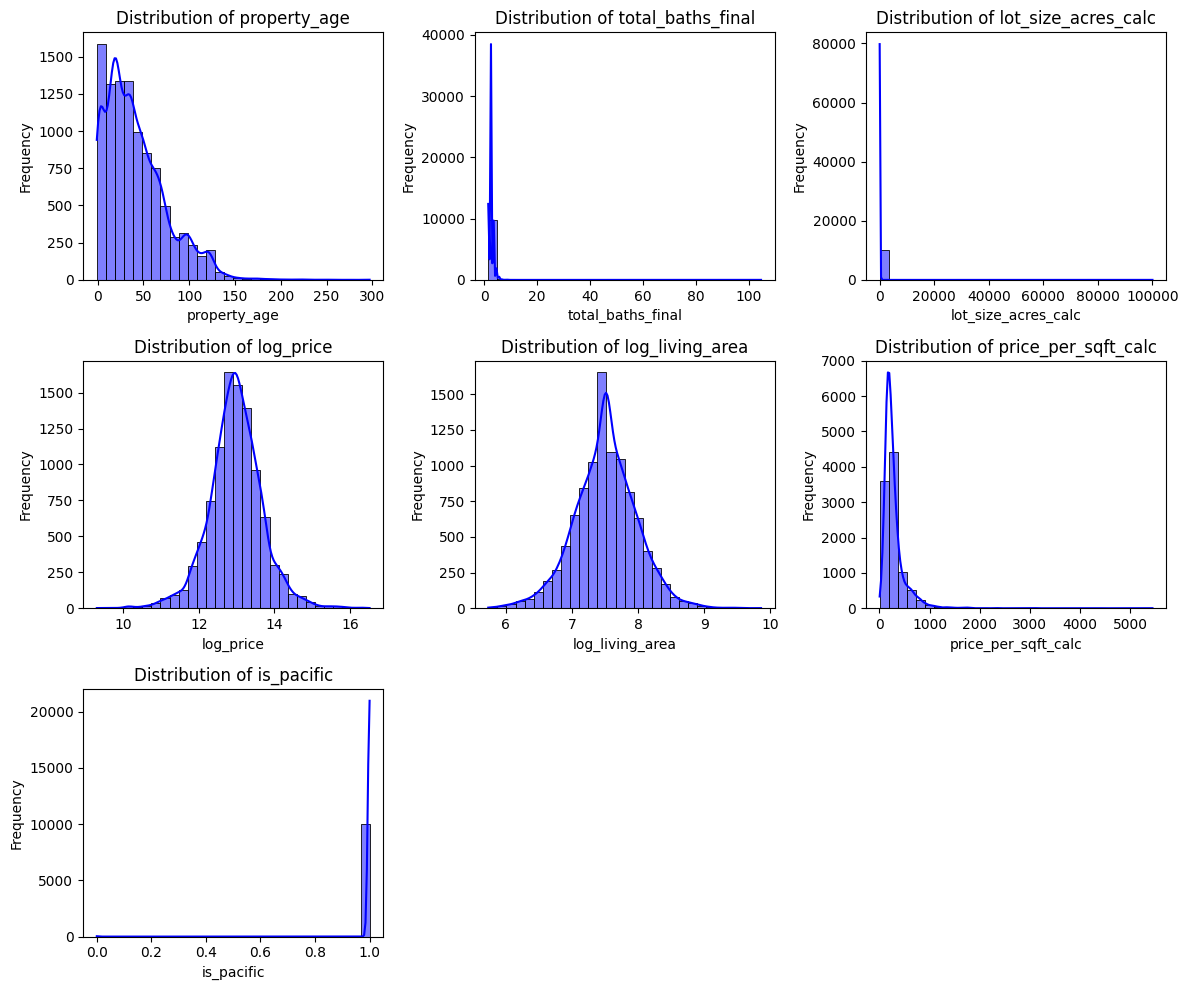

Feature distribution plots completed.

=== Starting Modeling ===
linear Regression done
Random forest done
SVR done
XGBR done
Model Evaluation Results generating:
--- LinearRegression ---
Saved model_metrics.json
--- RandomForest ---
Saved model_metrics.json
--- SVM ---
Saved model_metrics.json
--- XGBoost ---
Saved model_metrics.json
Model Evaluation Results:
--- LinearRegression ---
MAE: 120717.8998
RMSE: 237612.4649
R2: 0.7957
Accuracy: 0.9135
Precision: 0.8827
Recall: 0.9515
F1: 0.9158
ROC AUC: 0.9645

--- RandomForest ---
MAE: 8963.7169
RMSE: 70740.0759
R2: 0.9819
Accuracy: 0.9960
Precision: 0.9970
Recall: 0.9949
F1: 0.9960
ROC AUC: 0.9999

--- SVM ---
MAE: 272001.2141
RMSE: 538152.0644
R2: -0.0478
Accuracy: 0.8190
Precision: 0.7597
Recall: 0.9272
F1: 0.8352
ROC AUC: 0.9106

--- XGBoost ---
MAE: 21954.0993
RMSE: 177695.3123
R2: 0.8858
Accuracy: 0.9890
Precision: 0.9929
Recall: 0.9848
F1: 0.9888
ROC AUC: 0.9995

Random Forest Feature Importances:
                feature    importan

In [25]:
# main
df = load_data(DATA_PATH)
df_fe = feature_engineering(df)
plot_feature_distributions(df_fe)
lr_model, rf_model, svm_model, xgb_model, scaler, X_test, y_test, y_pred_lr, y_pred_rf, y_pred_svm, y_pred_xgb = train_models(df_fe)
generate_pdf_report(y_test, y_pred_lr, y_pred_rf, y_pred_svm, y_pred_xgb)


In [26]:
median_price = np.median(y_test)
y_test_class = (y_test > median_price).astype(int)


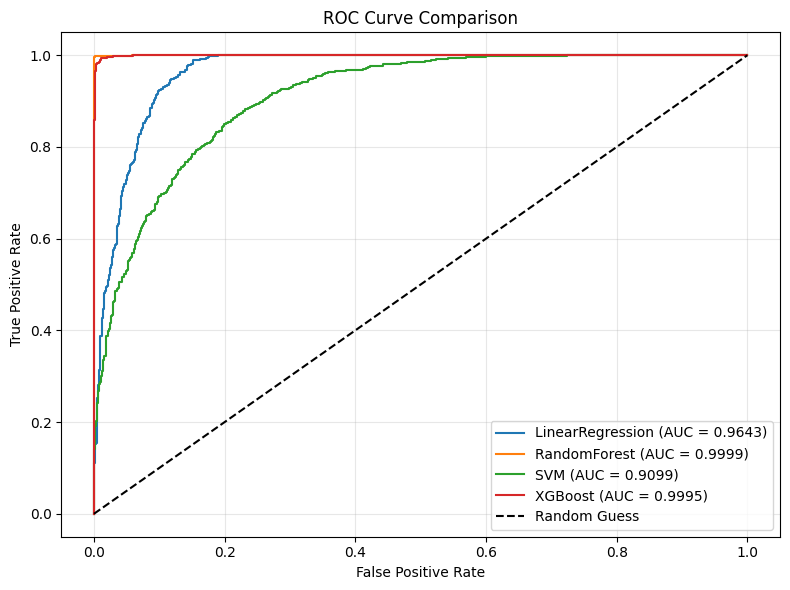

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curve plotting for all models
def plot_roc_curves(y_test, y_test_class, preds_dict):
    plt.figure(figsize=(8, 6))
    
    for model_name, y_pred in preds_dict.items():
        fpr, tpr, _ = roc_curve(y_test_class, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Prepare your predictions (must be real-valued outputs, not class labels)
preds_dict = {
    'LinearRegression': y_pred_lr,
    'RandomForest': y_pred_rf,
    'SVM': y_pred_svm,
    'XGBoost': y_pred_xgb
}

# Plot all ROC curves
plot_roc_curves(y_test, y_test_class, preds_dict)



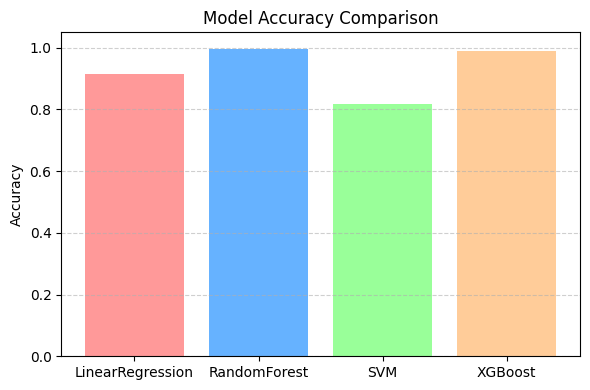

In [29]:
import json
import matplotlib.pyplot as plt

# Load metrics from saved JSON
with open("../Data/model_metrics.json", "r") as f:
    metrics_dict = json.load(f)

# Extract model names and their accuracies
model_names = list(metrics_dict.keys())
accuracies = [metrics_dict[model]["Accuracy"] for model in model_names]

# Define custom colors for each bar
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']  # You can change these

# Create Accuracy Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies, color=colors)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and Show
plt.savefig("../Reports/Graphs/Recall_bar_chart_colored.png")
plt.show()


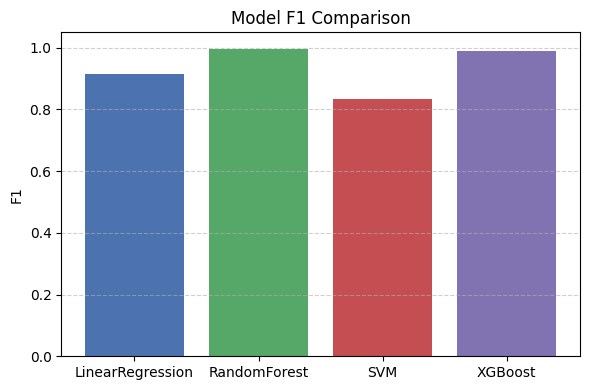

In [30]:
import json
import matplotlib.pyplot as plt

# Load metrics from saved JSON
with open("../Data/model_metrics.json", "r") as f:
    metrics_dict = json.load(f)

# Extract model names and their accuracies
model_names = list(metrics_dict.keys())
f1 = [metrics_dict[model]["F1"] for model in model_names]

# Define custom colors for each bar
colors = ['#4C72B0',  # blue
          '#55A868',  # green
          '#C44E52',  # red
          '#8172B2']  # purple


# Create Accuracy Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, f1, color=colors)
plt.title("Model F1 Comparison")
plt.ylabel("F1")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and Show
plt.savefig("../Reports/Graphs/Recall_bar_chart_colored.png")
plt.show()


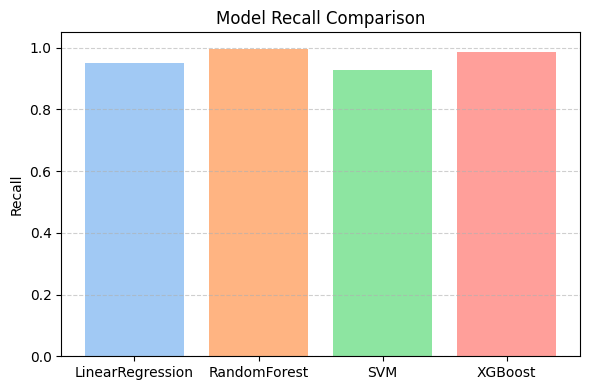

In [31]:
import json
import matplotlib.pyplot as plt

# Load metrics from saved JSON
with open("../Data/model_metrics.json", "r") as f:
    metrics_dict = json.load(f)

# Extract model names and their Recall
model_names = list(metrics_dict.keys())
Recall = [metrics_dict[model]["Recall"] for model in model_names]

colors = ['#A1C9F4',  # baby blue
          '#FFB482',  # soft orange
          '#8DE5A1',  # mint green
          '#FF9F9A']  # soft red

# Create Recall Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, Recall, color=colors)
plt.title("Model Recall Comparison")
plt.ylabel("Recall")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and Show
plt.savefig("../Reports/Graphs/Recall_bar_chart_colored.png")
plt.show()


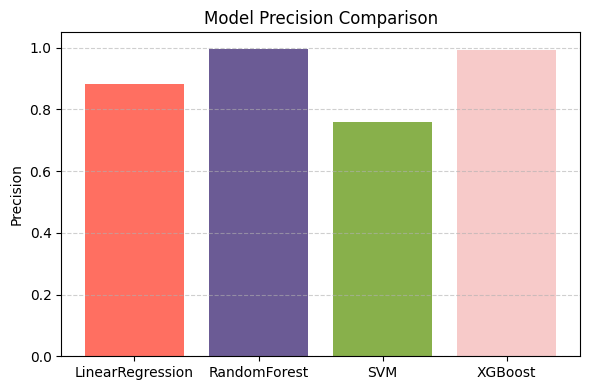

In [32]:
# Load metrics from saved JSON
with open("../Data/model_metrics.json", "r") as f:
    metrics_dict = json.load(f)

# Extract model names and their Recall
model_names = list(metrics_dict.keys())
Precision = [metrics_dict[model]["Precision"] for model in model_names]

colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']


# Create Recall Bar Chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, Precision, color=colors)
plt.title("Model Precision Comparison")
plt.ylabel("Precision")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and Show
plt.savefig("../Reports/Graphs/Recall_bar_chart_colored.png")
plt.show()
